In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [243]:
import warnings
from collections import defaultdict
import itertools
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.preprocessing import PolynomialFeatures 
from sklearn.preprocessing import SplineTransformer

from sklearn.linear_model import Ridge, LinearRegression, SGDRegressor

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn import svm

from bgspy.learn import LearnedFunction, LearnedB
from bgspy.theory import bgs_segment


In [258]:
def Xy_to_ndarray(X, y):
    dims = []
    for i in range(X.shape[1]):
        dims.append(len(np.unique(X[:, i])))
    X_values = dict()
    X_map = defaultdict(dict)
    for i in range(X.shape[1]):
        vals = sorted(np.unique(X[:, i]))
        for j, val in enumerate(vals):
            X_map[i][val] = j
    yy = np.empty(dims)
    for i in range(X.shape[0]):
        idx = []
        for j in range(X.shape[1]):
            idx.append(X_map[j][X[i, j]])
        yy[tuple(idx)] = y[i]
    return yy, X_map

yg, params = Xy_to_ndarray(X, y)

In [261]:
params

defaultdict(dict,
            {0: {1e-10: 0,
              5.62341325e-10: 1,
              3.16227766e-09: 2,
              1.77827941e-08: 3,
              1e-07: 4},
             1: {1e-06: 0, 1e-05: 1, 0.0001: 2, 0.001: 3, 0.01: 4, 0.1: 5},
             2: {0.0: 0, 1.0: 1, 100.0: 2, 500.0: 3, 1000.0: 4},
             3: {1e-12: 0, 3.16227766e-10: 1, 1e-07: 2},
             4: {1e-10: 0,
              4.13518554e-09: 1,
              1.70997595e-07: 2,
              7.07106781e-06: 3,
              0.000292401774: 4,
              0.0120913559: 5,
              0.5: 6}})

[]

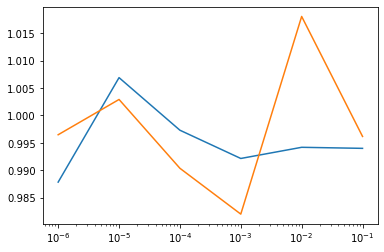

In [271]:
plt.plot(list(params[1].keys()), yg[2, :, 4, 0, 0])
plt.plot(list(params[1].keys()), yg[2, :, 4, 1, 0])

plt.semilogx()

In [253]:
#f = LearnedFunction.load("../data/slim_sims/bmap_hg38_manyreps/bmap_hg38_manyreps_raw.pkl")
f = LearnedFunction.load("../data/slim_sims/bmap_hg38_grid/bmap_hg38_grid_raw.pkl")
f.split()

LearnedFunction with 5 feature(s)
 variable feature(s):
  - mu ∈ [1e-10, 1e-07] (linear, None)
  - sh ∈ [1e-06, 0.1] (linear, None)
  - L ∈ [0.0, 1000] (linear, None)
  - rbp ∈ [1e-12, 1e-07] (linear, None)
  - rf ∈ [1e-10, 0.5] (linear, None)
 fixed fixed(s) (based on metadata):
Features normalized? False
Features split? True, test size: 20.0% (n=630)
Total size: 3,150

In [254]:
# if log transform y
regressor = LinearRegression()
regr = TransformedTargetRegressor(regressor=Ridge(),
                                  func=np.log,
                                  inverse_func=np.exp)

In [255]:
pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('poly', PolynomialFeatures()), 
                       #('spline', SplineTransformer()),                        
                       ('regr', Ridge())])

X = f.X
y = f.y

In [238]:
X[:, 0]

array([5.62341325e-10, 1.77827941e-08, 1.77827941e-08, ...,
       1.77827941e-08, 5.62341325e-10, 1.77827941e-08])

In [239]:
idx = (X[:, 0] == 1.77827941e-08) & (X[:, 2] == 1000) & (X[:, 4] == 1e-10) & (X[:, 3] == 1.00000000e-07)
X = X[idx, :]
y = y[idx]

[]

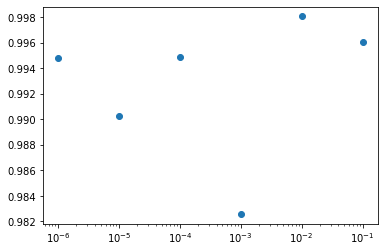

In [241]:
plt.scatter(X[:, 1], y)
plt.semilogx()

In [201]:
2 * np.sqrt(5/(9* 10000))

0.014907119849998597

In [212]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pipe.fit(X, y)

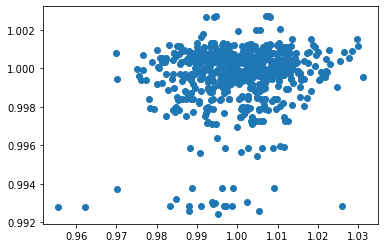

In [213]:
plt.scatter(f.y_test, pipe.predict(f.X_test))

In [214]:
def binned_plot(model, X_test, y_test, nbins):
    ypred = model.predict(X_test)
    bins = np.linspace(ypred.min(), ypred.max(), nbins)
    y_bins = stats.binned_statistic(ypred, y_test, bins=nbins)
    edges = y_bins.bin_edges
    x = 0.5*(edges[:-1]+edges[1:])
    y =  y_bins.statistic
    plt.scatter(x, y)
    o = min(edges)
    plt.axline((o, o), slope=1, c='r')
    xx, yy = x[y <= 1], y[y <= 1]
    return np.nanmean((xx-yy)**2)
    
binned_plot(pipe, X, y, 50)

ValueError: too many values to unpack (expected 2)

In [215]:
param_grid = {#'spline__n_knots': [3, 5, 10], 
              #'spline__degree': np.arange(1, 10), 
              'poly__degree': np.arange(1, 10),
              #'regr__regressor__alpha': np.logspace(-3, 2, 10)}
              'regr__alpha': np.logspace(-3, 2, 10)}
              

In [216]:
def bhat_scorer(y_true, y_pred):
    w = (y_true - y_pred)**2
    w[(y_true > 1) | (y_pred > 1)] = np.nan
    return np.nanmean(w)

bhat_scorer = make_scorer(bhat_scorer, greater_is_better=False)

In [217]:
search = GridSearchCV(pipe, param_grid, 
                      #scoring=bhat_scorer,
                      #scoring='neg_mean_squared_error', 
                      cv=5, n_jobs=50)

In [218]:
search.fit(f.X_train, f.y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('poly', PolynomialFeatures()),
                                       ('regr', Ridge())]),
             n_jobs=50,
             param_grid={'poly__degree': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'regr__alpha': array([1.00000000e-03, 3.59381366e-03, 1.29154967e-02, 4.64158883e-02,
       1.66810054e-01, 5.99484250e-01, 2.15443469e+00, 7.74263683e+00,
       2.78255940e+01, 1.00000000e+02])})

In [219]:
print(search.best_params_)

{'poly__degree': 2, 'regr__alpha': 27.825594022071257}


6.662503244827189e-05


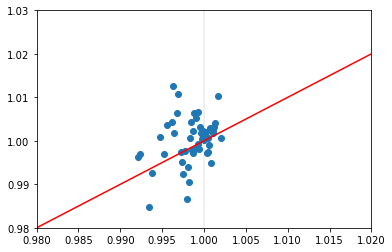

In [221]:
print(binned_plot(search, f.X_test, f.y_test, 100))
o = 0.98
plt.xlim(o, 1.02)
plt.ylim(o, 1.03)
plt.axvline(1, c='0.22', alpha=0.1, zorder=-1)

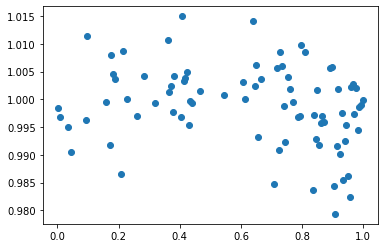

In [222]:
X = f.X_train_raw
btheory = bgs_segment(*X.T)
rate = X[:, 0] / X[:, 1]
x = btheory
y = f.y_train #pipe.predict(X)

nbins = 190
bins = np.linspace(y.min(), y.max(), nbins)
y_bins = stats.binned_statistic(x, y, bins=nbins)
edges = y_bins.bin_edges
x = 0.5*(edges[:-1]+edges[1:])
yb =  y_bins.statistic

#idx = np.arange(X.shape[0])#rate > 1e-4
idx = rate > 1e-4

plt.scatter(x, yb)


In [223]:
btheory, y

(array([0.99999438, 1.        , 1.        , ..., 1.        , 0.99999998,
        0.99999806]),
 array([0.97640187, 1.00744606, 0.9975146 , ..., 0.99817677, 0.99957943,
        0.99108842]))

[]

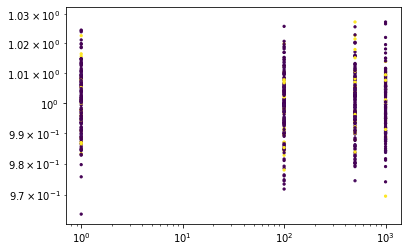

In [224]:
plt.scatter(X[idx, 2], y[idx], s=5, c=X[idx, 4])
plt.loglog()

In [225]:
X_

array([[1.00000000e-10, 1.00000000e-05],
       [1.00000000e-10, 1.09749877e-05],
       [1.00000000e-10, 1.20450354e-05],
       ...,
       [1.00000000e-08, 8.30217568e-02],
       [1.00000000e-08, 9.11162756e-02],
       [1.00000000e-08, 1.00000000e-01]])

In [226]:
n = 100

X_ = np.array(list(itertools.product(np.logspace(-10, -8, n), np.logspace(-5, -1, n))))
n = X_.shape[0]

L = np.array([1000]*n)[:, None]
rf = np.array([1e-9]*n)[:, None]
rbp = np.array([1e-8]*n)[:, None]

X_test = np.concatenate([X_, L, rbp, rf], axis=1)

[]

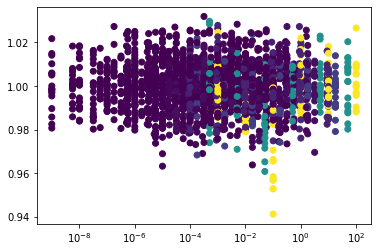

In [227]:
plt.scatter(X[:, 2]*X[:, 0]/X[:, 1], y, c=X[:, 0]*X[:, 2])
plt.semilogx()

In [228]:
5/(9*2000)

0.0002777777777777778

[]

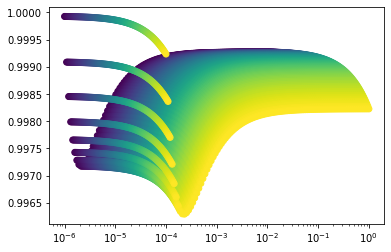

In [237]:
plt.scatter(X_test[:, 2]*X_test[:, 0]/X_test[:, 1], pipe.predict(X_test), c=np.log10(X_test[:, 0]))
#plt.scatter(X_test[:, 2]*X_test[:, 0]/X_test[:, 1], bgs_segment(*X_test.T))
plt.semilogx()

In [232]:
print(binned_plot(pipe, f.X_test, f.y_test, 100))
plt.xlim(0.92, 1.02)
plt.ylim(0.9, 1.03)
plt.axvline(1, c='0.22', alpha=0.1, zorder=-1)

ValueError: too many values to unpack (expected 2)